# ARIMA Modeling with PepsiCo Stock Price

### MSDS 7333-4023
### Unit 4: Case Study - Financial Applications of Time Series
### Name: Mooyoung Lee

## <span style="color:blue"> Objective:  

### The goal is to understand a modeling procedure in time series analysis.  An Autoregressive Integrated Moving Average (ARIMA) model will be used to fit to a choice of stock data.  The logical selection of the hyperparameters p, d, and q of the ARIMA model will be the focus of this study.

## <span style="color:blue"> Background:

### ARIMA model is a general method of forecating a time series data.   ARIMA assumes to be stationary by differencing and with data transformation (e.g. log-transformation) if necessary.  

### A stationary data should have a constant mean and variance. Otherwise, ARIMA model should not be applied to a data set.  
<br />

## ARIMA model is described as "ARIMA(p, d, q)", where:

### * p is the order order of autoregression,
### * d is the order of differences for stationarity, and
### * q is the number for moving average
<br />

### See below site for the details of ARIMA equations
source: <https://people.duke.edu/~rnau/411arim.htm>


## <span style="color:blue"> Method:


### 1. Dickey-Fuller test will be used to check stationarity, which is an assumption of ARIMA model

### 2. ARIMA parameters p, d, and q will be estimated by interpreting Autocorrelation and Partial Autocorrelation plots. 

### 3.  A Brute-Force method will be used to find the ARIMA parameters by trying all probable combinations. 

### 4. Final ARIMA parameters will be determined based on the plot interpretation and the brute-force methods. 


# <span style="color:red"> Stock data download

PepsiCo company stock is chosen randomly.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [12, 8]

import numpy as np
import pandas as pd
import datetime
pd.core.common.is_list_like = pd.api.types.is_list_like
from pandas_datareader import data as web

start = datetime.datetime(2014, 6, 1)
end = datetime.datetime(2018, 6, 1)
# price = web.DataReader('COF', 'iex', start, end)['close']  # capical one
# price = web.DataReader('CAT', 'iex', start, end)['close']
price = web.DataReader('PEP', 'iex', start, end)['close']
price.index = pd.to_datetime(price.index)
price.head()

5y


date
2014-06-02    77.7036
2014-06-03    78.0131
2014-06-04    77.8929
2014-06-05    78.1869
2014-06-06    78.3205
Name: close, dtype: float64

# <span style="color:red"> Step1: Stationarity Check

## Plot raw data of closing stock price


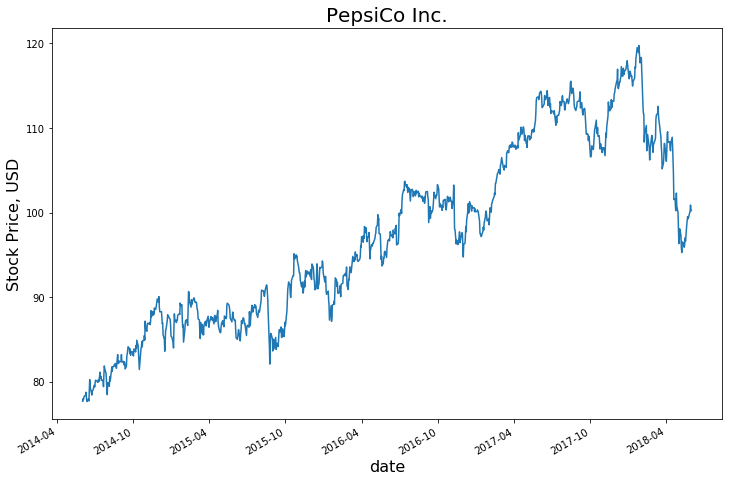

In [2]:
plt.title('PepsiCo Inc.', fontsize=20)
plt.ylabel('Stock Price, USD', fontsize=16)
plt.xlabel('Date', fontsize=16)
price.plot()

## A Function for the Stationarity Test using Dickey-Fuller theory

### Monthly(30day) moving average and standard deviation are overlayed to be able to check the trend more clearly.

In [3]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = timeseries.rolling(30).mean()
    rolstd = timeseries.rolling(30).std()

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation', fontsize=20)
    plt.ylabel('Stock Price, USD or transformed USD', fontsize=16)
    plt.xlabel('Date', fontsize=16)
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

C:\Users\ML\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


## <span style="color:red"> Stationarity check with raw data

### With the test statistics and the p-value shown below, the raw data is not stationary.  

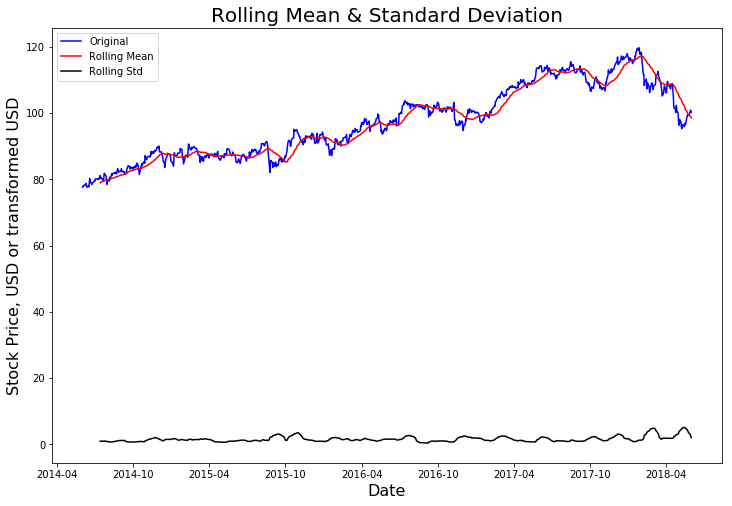

Results of Dickey-Fuller Test:
Test Statistic                   -1.883883
p-value                           0.339681
#Lags Used                        0.000000
Number of Observations Used    1008.000000
Critical Value (1%)              -3.436854
Critical Value (5%)              -2.864412
Critical Value (10%)             -2.568299
dtype: float64


In [4]:
test_stationarity(price)

## <span style="color:red"> Stationarity check w/ a first-order difference

### The below test statistics and p-value with a first-order difference is stationary with more than 99% confidence. Thus, ARIMA model can be applied to this data set. 

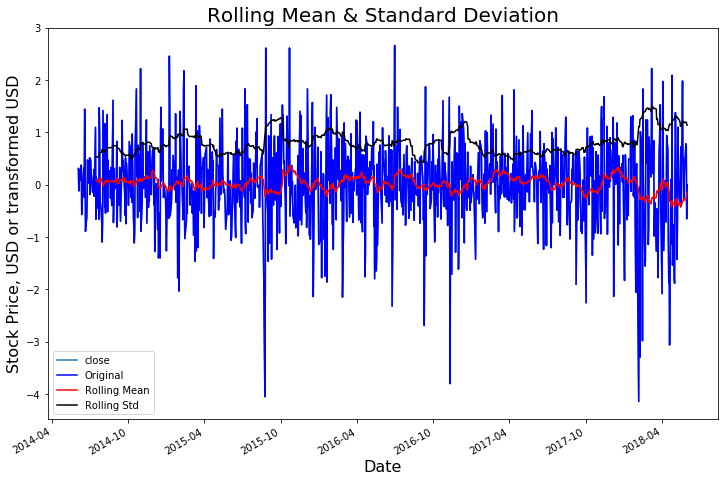

Results of Dickey-Fuller Test:
Test Statistic                  -31.313231
p-value                           0.000000
#Lags Used                        0.000000
Number of Observations Used    1007.000000
Critical Value (1%)              -3.436860
Critical Value (5%)              -2.864414
Critical Value (10%)             -2.568300
dtype: float64


In [5]:
# first-order difference
diff=price-price.shift()
diff.dropna(inplace=True)
diff.plot()
test_stationarity(diff)

## <span style="color:red"> Stationarity check w/ a second-order difference

### The below test statistics shows that the stationarity with the first-order differencing is better than the second-order differencing.  The reasonable guess for the ARIMA d parameter will be 1 since the first-order differencing shows the highest stationarity compared to the raw and the second-order differencing. 

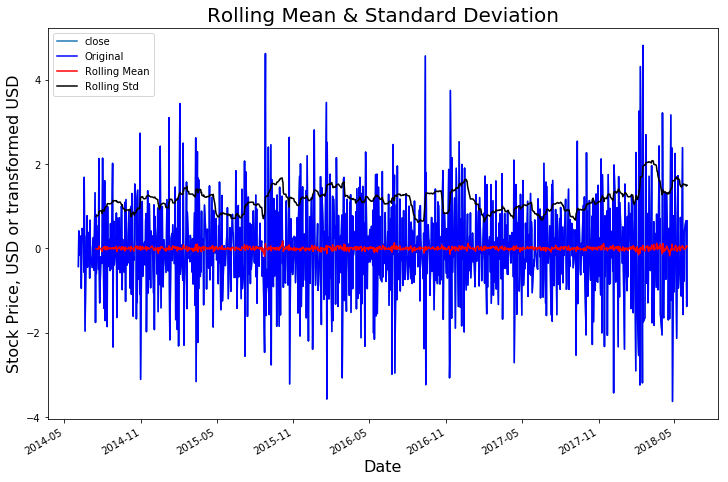

Results of Dickey-Fuller Test:
Test Statistic                -1.199531e+01
p-value                        3.445022e-22
#Lags Used                     2.100000e+01
Number of Observations Used    9.850000e+02
Critical Value (1%)           -3.437006e+00
Critical Value (5%)           -2.864479e+00
Critical Value (10%)          -2.568335e+00
dtype: float64


In [6]:
# second order difference
diff = price-price.shift()
diff2 = diff - diff.shift()
diff2.dropna(inplace=True)
diff2.plot()
test_stationarity(diff2)

# <span style="color:red"> Step2: Autocorrelation and Partial Autocorrelation Plot 

###  Below autocorrelation function with raw data shows high correlations to more than 10 lags.  This indicate a higher order of differencing.  

Text(0.5,0,'lag')

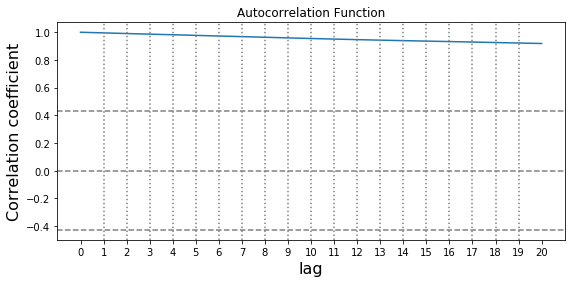

In [7]:
from statsmodels.tsa.stattools import acf, pacf
acf_air_plot = acf(price.dropna(), nlags=20)
#Plot ACF: 
plt.figure(figsize=(20, 4))

plt.subplot(121) 
plt.plot(acf_air_plot)
plt.xticks(np.arange(21))
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(acf_air_plot)),linestyle='--',color='gray') # lower bound
plt.axhline(y=1.96/np.sqrt(len(acf_air_plot)),linestyle='--',color='gray')  # upper bound
for i in range(1,20):
    plt.axvline(x=i,linestyle=':',color='gray')
plt.title('Autocorrelation Function')
plt.ylabel('Correlation coefficient', fontsize=16)
plt.xlabel('lag', fontsize=16)

### The dotted lines around zero are the 95% significance bounds which indicate an autoregressive process.  

### The autocorrelation function with a first-order difference shows a very low correlation from the lag-1.  This indicate that no higher order of differencing is needed.  Thus, ARIMA parameter d can be 1.

### Since the lag-1 correlation did not go below zero.  This means that the order of differencing do not need to be reduced.  Also, it is indicating that the order of MA(moving average) term do not need to be increased.  Thus, the ARIMA q parameter can be 0 based on this autocorrelation function.


Text(0.5,0,'lag')

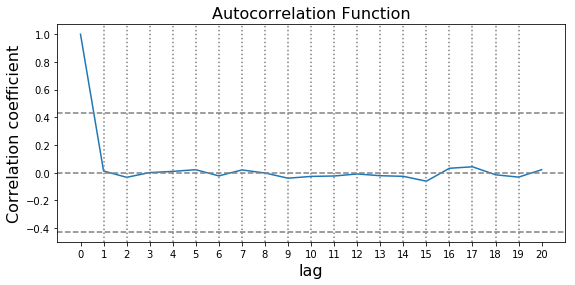

In [8]:
from statsmodels.tsa.stattools import acf, pacf
acf_air_plot = acf(diff.dropna(), nlags=20)
#Plot ACF: 
plt.figure(figsize=(20, 4))

plt.subplot(121) 
plt.plot(acf_air_plot)
plt.xticks(np.arange(21))
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(acf_air_plot)),linestyle='--',color='gray') # lower bound
plt.axhline(y=1.96/np.sqrt(len(acf_air_plot)),linestyle='--',color='gray')  # upper bound
for i in range(1,20):
    plt.axvline(x=i,linestyle=':',color='gray')
plt.title('Autocorrelation Function', fontsize=16)
plt.ylabel('Correlation coefficient', fontsize=16)
plt.xlabel('lag', fontsize=16)

## Also, the first-order differencing showed the lowest standard deviation.  This suggest the first-order difference can be a good estimation.  

Text(0.5,0,'Order of Differencing')

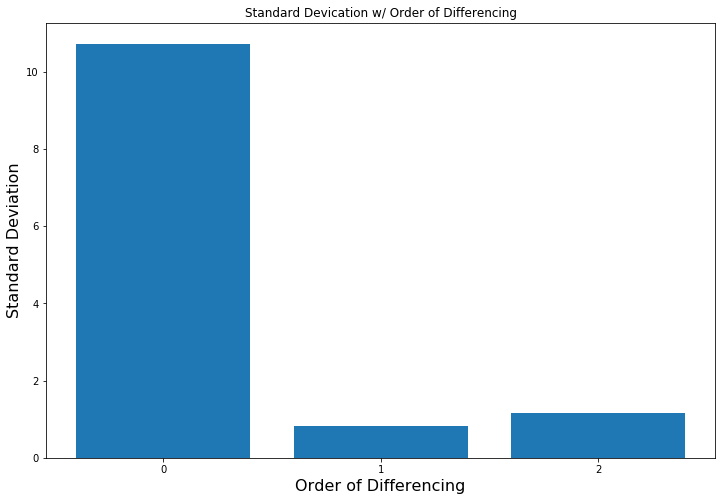

In [9]:
plt.bar([0,1,2],[np.std(price), np.std(diff), np.std(diff2)])
plt.xticks([0,1,2])
plt.title('Standard Devication w/ Order of Differencing')
plt.ylabel('Standard Deviation', fontsize=16)
plt.xlabel('Order of Differencing', fontsize=16)

### Below partial autocorrelation function with raw data shows high positive correlation at lag-1.  This indicate the series is underdifferenced.  Then either AR term or the differencing(I) term can be increased.

Text(0.5,0,'lag')

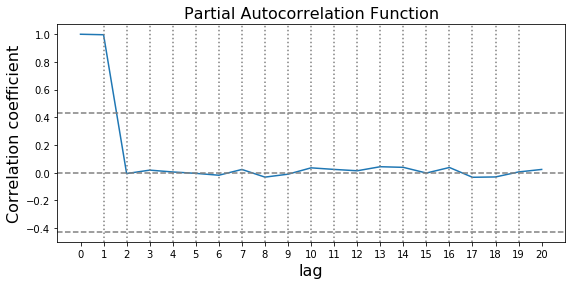

In [10]:
pacf_air_plot = pacf(price.dropna(), nlags=20)
#Plot ACF: 
plt.figure(figsize=(20, 4))

plt.subplot(121) 
plt.plot(pacf_air_plot)
plt.xticks(np.arange(21))
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(acf_air_plot)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(acf_air_plot)),linestyle='--',color='gray')
for i in range(1,20):
    plt.axvline(x=i,linestyle=':',color='gray')
plt.title('Partial Autocorrelation Function', fontsize=16)
plt.ylabel('Correlation coefficient', fontsize=16)
plt.xlabel('lag', fontsize=16)

### Below partial autocorrealtion function with first-order differencing shows no significant correlation value.  This indicate the differenced series is not underdifferenced.  Then, it is not necessary to add AR terms while the first-order of differencing term is existing.  The ARIMA parameter p based on this plot will be 0 with a first-order of differencing.  

Text(0.5,0,'lag')

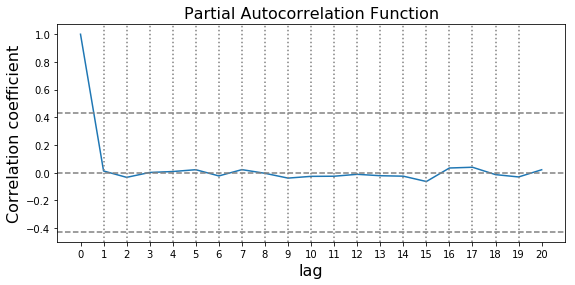

In [11]:
pacf_air_plot = pacf(diff.dropna(), nlags=20)
#Plot ACF: 
plt.figure(figsize=(20, 4))

plt.subplot(121) 
plt.plot(pacf_air_plot)
plt.xticks(np.arange(21))
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(acf_air_plot)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(acf_air_plot)),linestyle='--',color='gray')
for i in range(1,20):
    plt.axvline(x=i,linestyle=':',color='gray')
plt.title('Partial Autocorrelation Function', fontsize=16)
plt.ylabel('Correlation coefficient', fontsize=16)
plt.xlabel('lag', fontsize=16)

 ###  Based on the stationarity and the autocorrelation plots, the ARIMA(0,1,0) is suggested.  ARIMA(0,1,0) is a random walk which means the past data have no meaning to predict the future points.  This is understandable since the stock price is hard to predict and there are so many ups and downs so the up/down movements are occuring almost equally.  

##  <span style="color:red"> Step 3: Brute-Force ARIMA Model Optimization w/ RMSE loss function

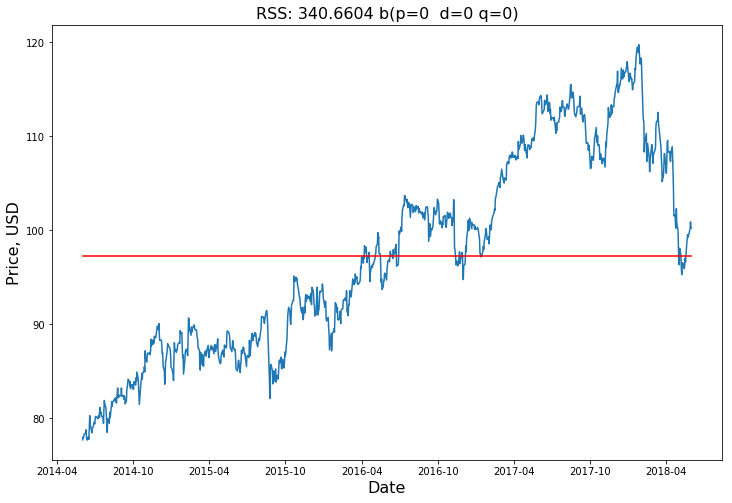

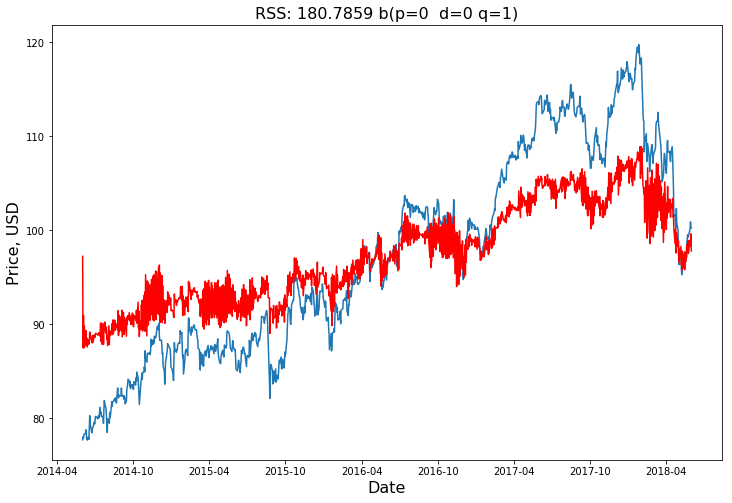

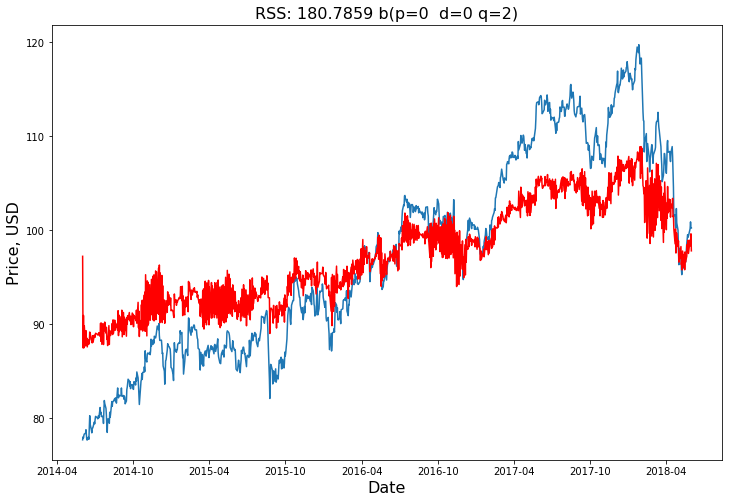

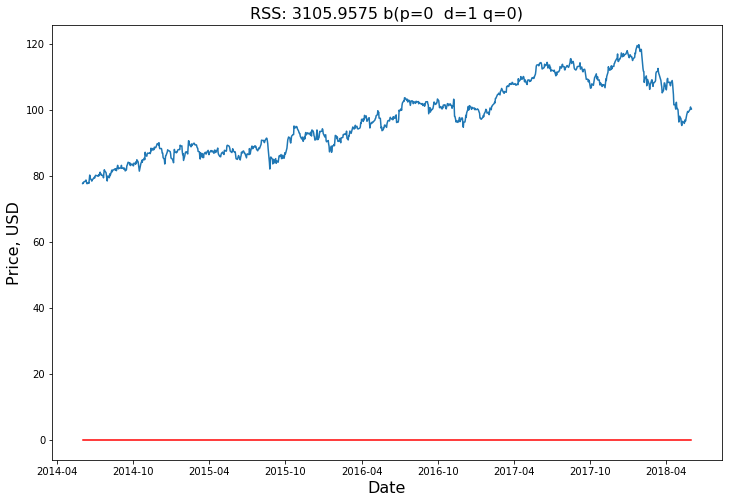

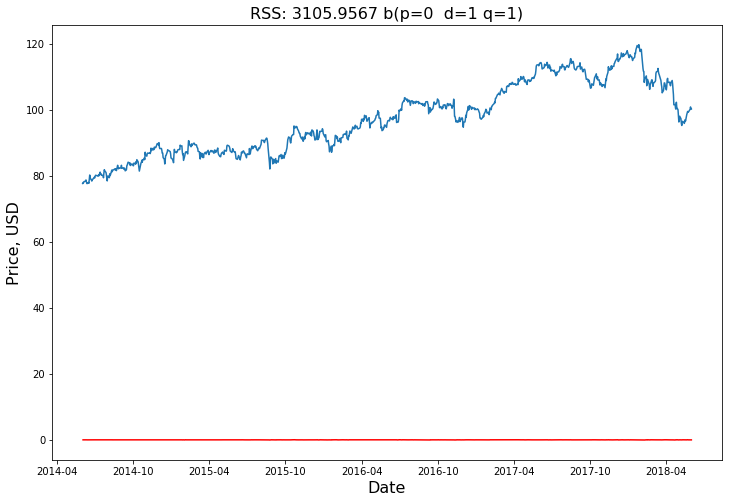

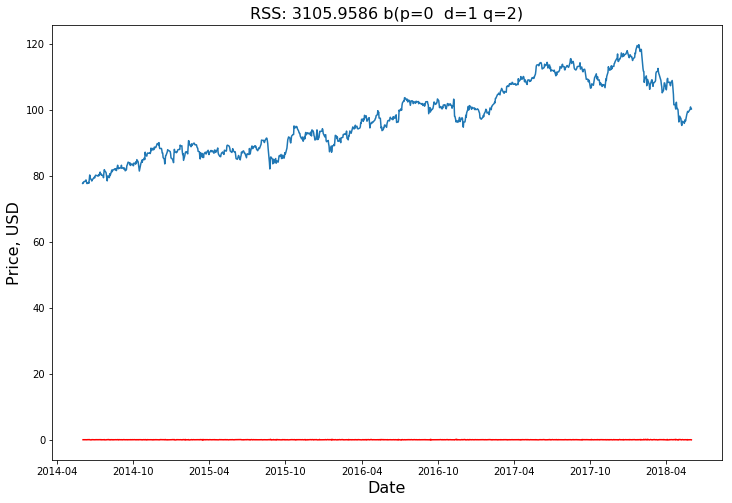

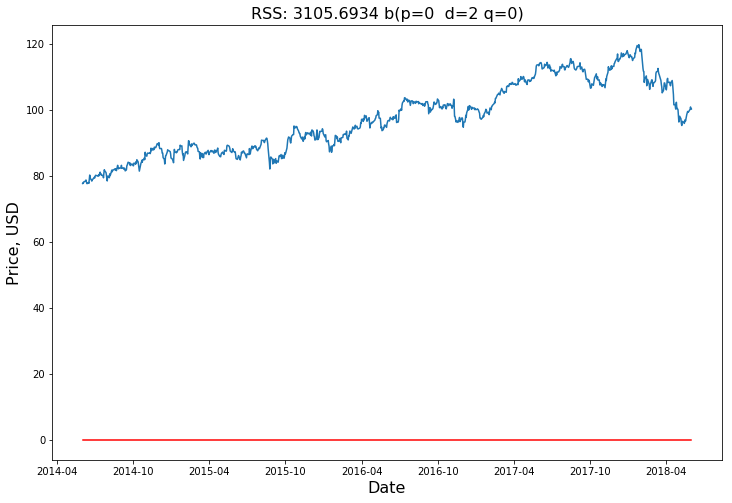

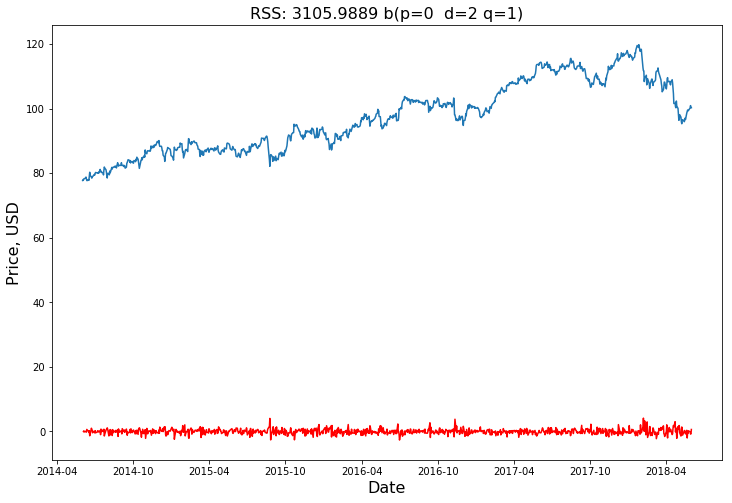

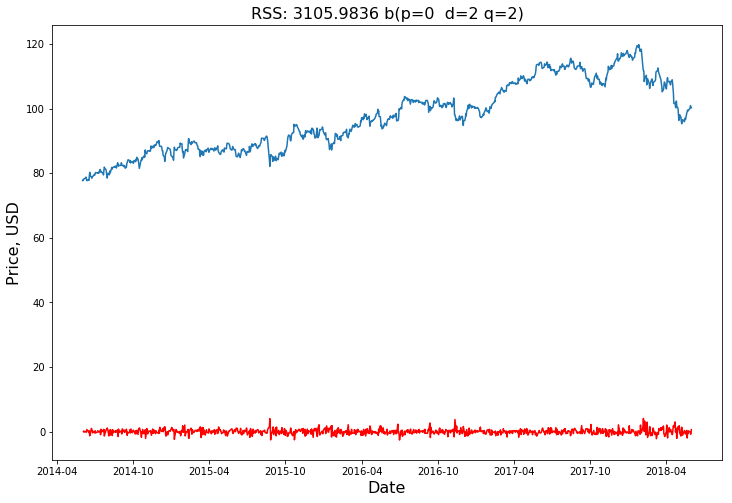

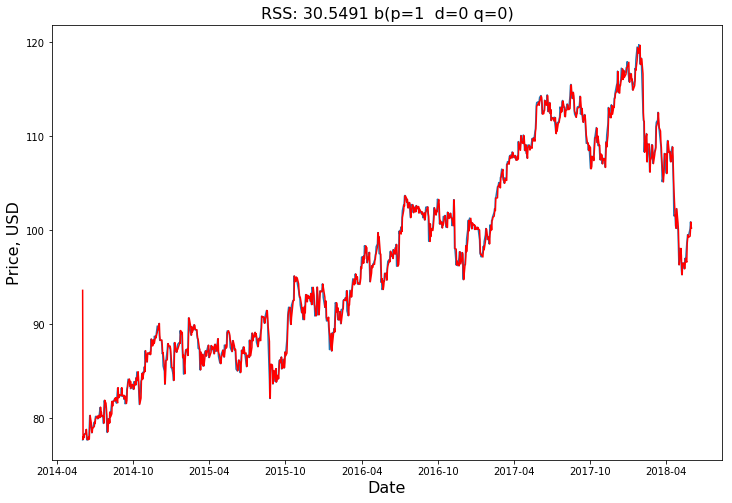

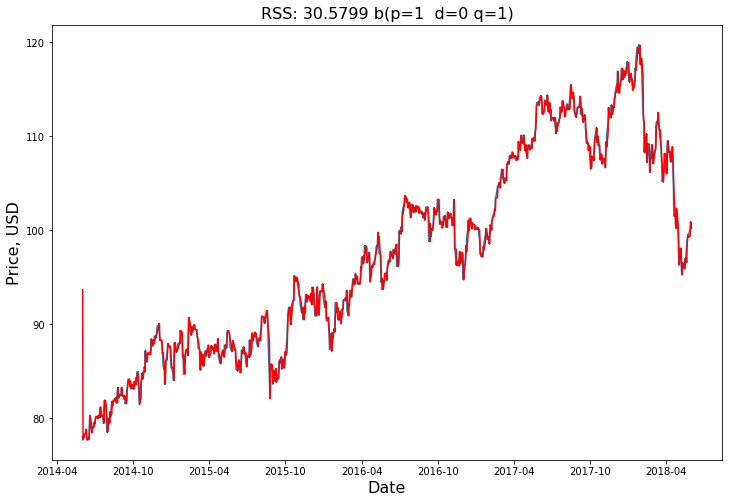

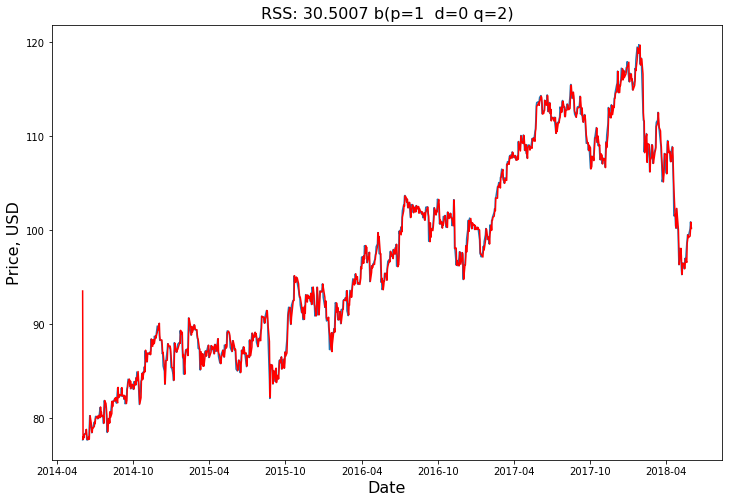

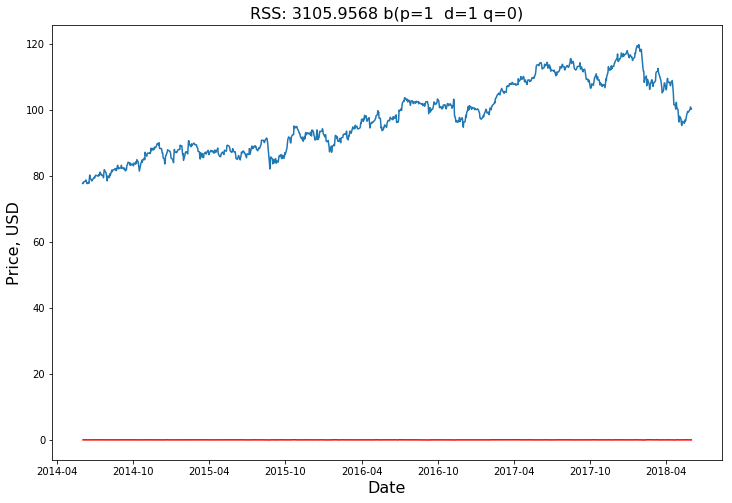

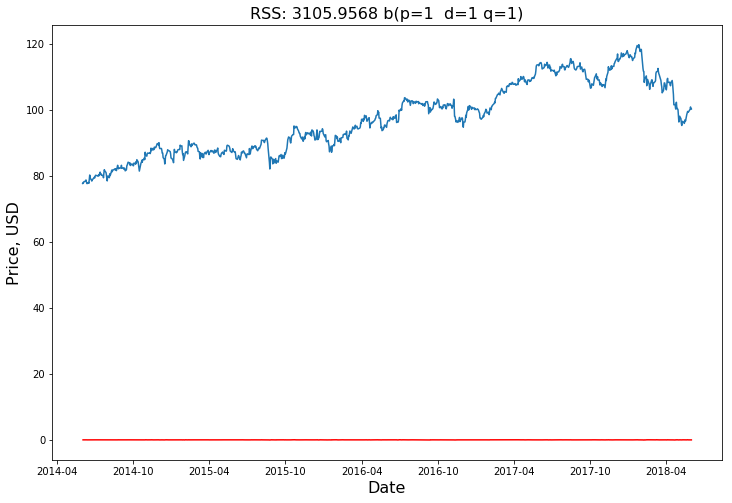

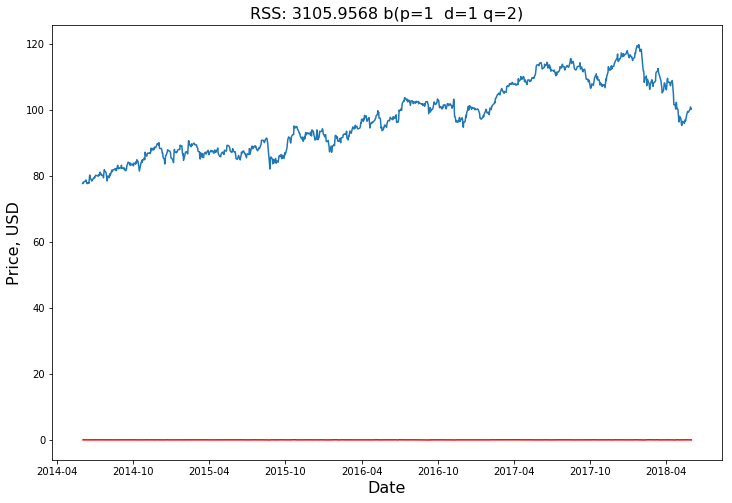

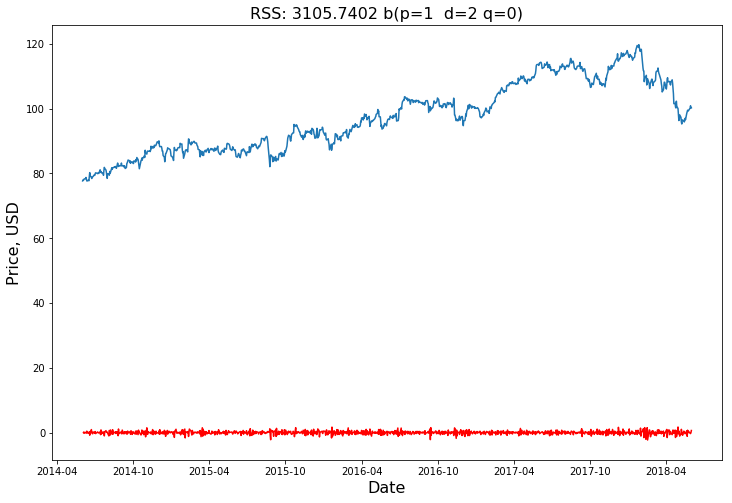

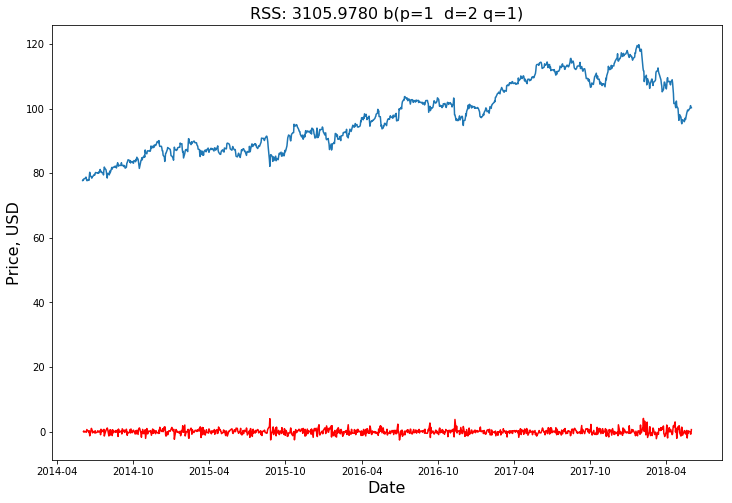

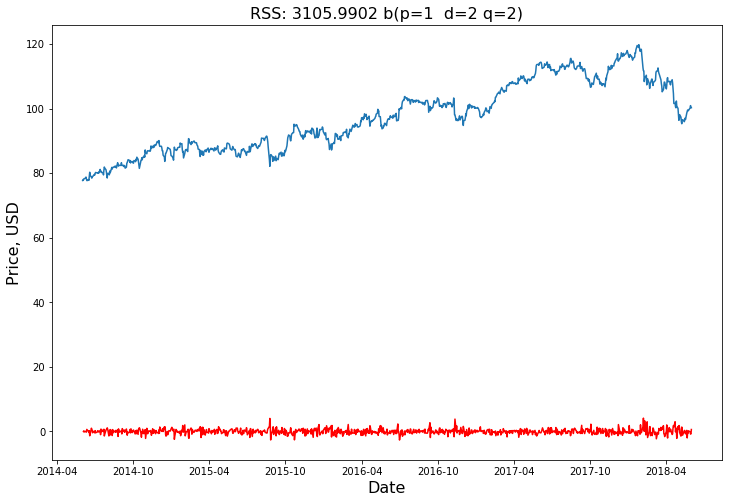

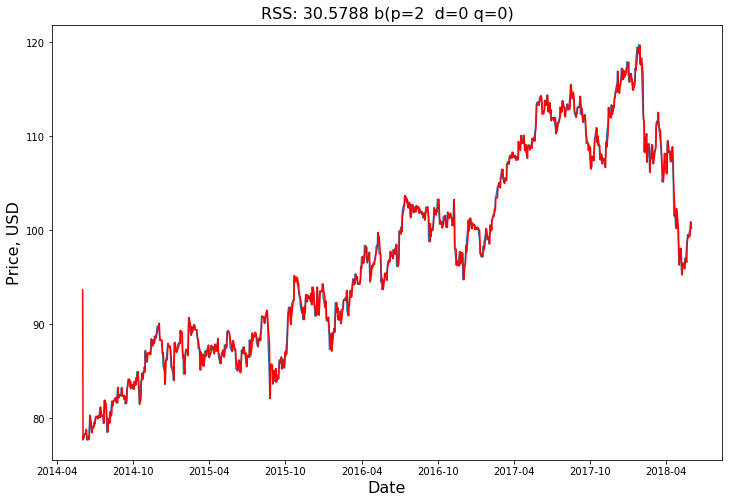

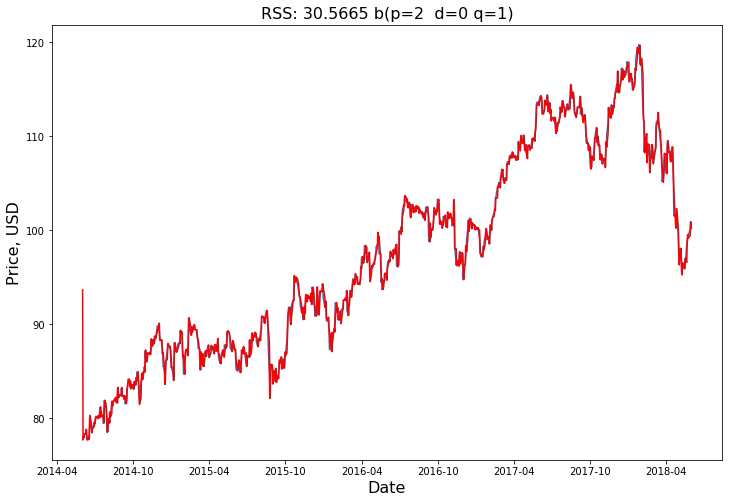

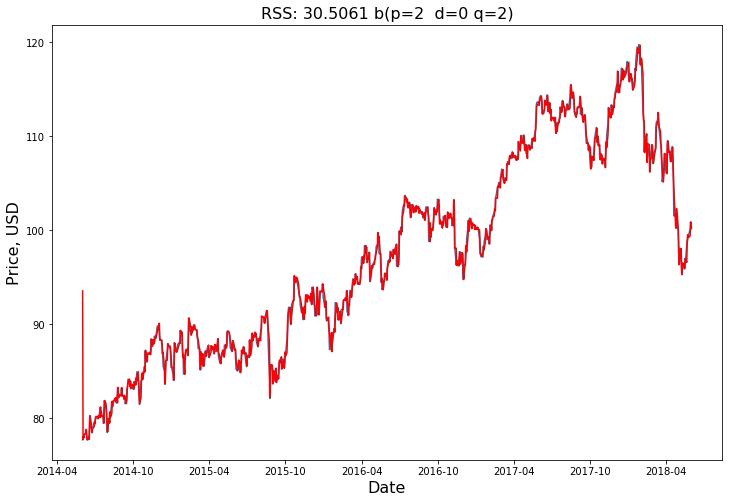

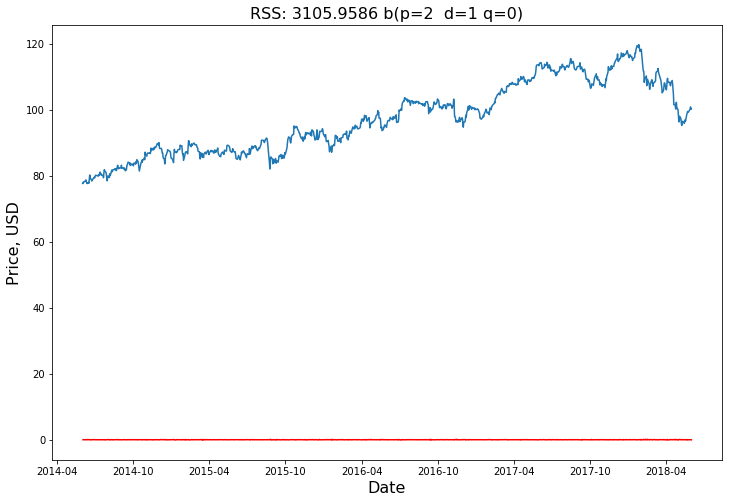

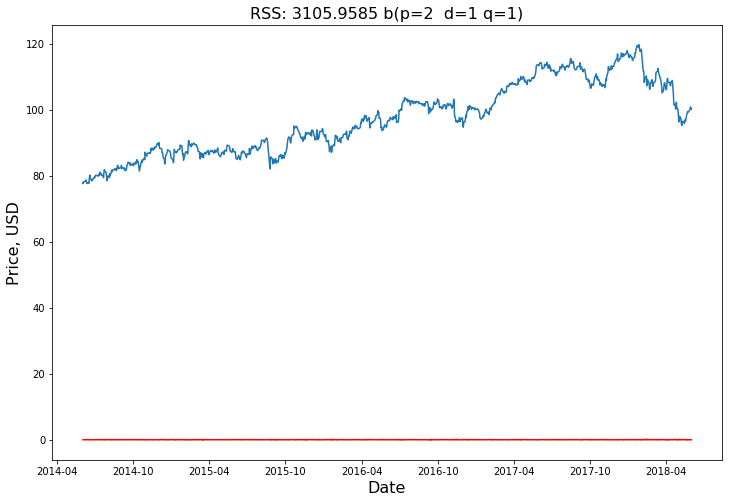

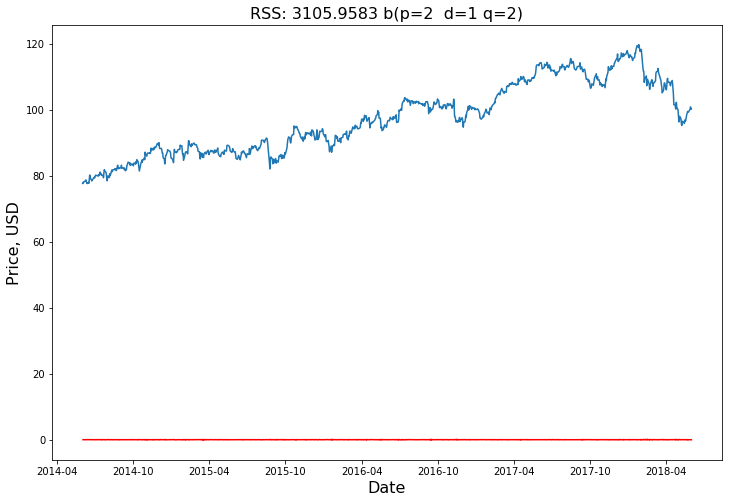

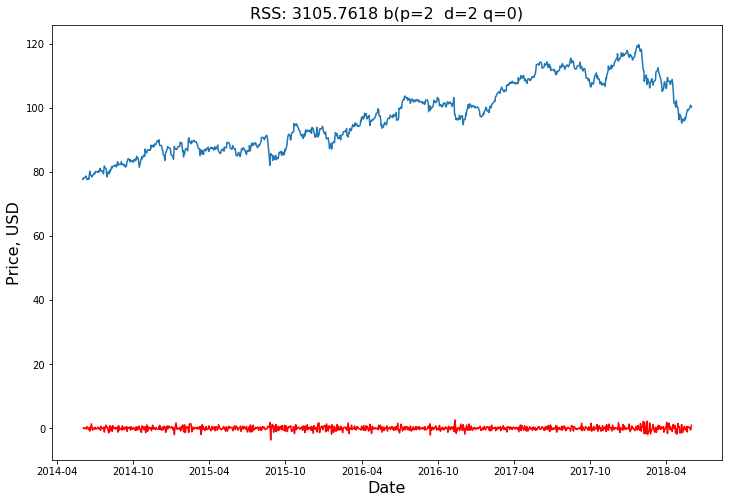

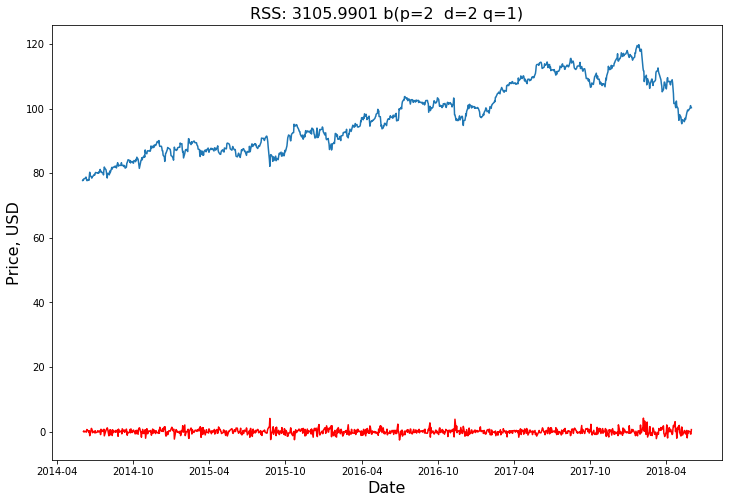

C:\Users\ML\Anaconda3\lib\site-packages\statsmodels\base\model.py:473: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\ML\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


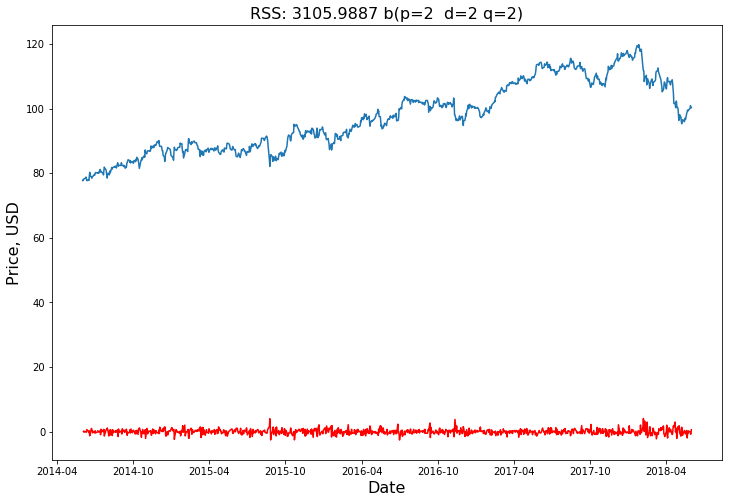

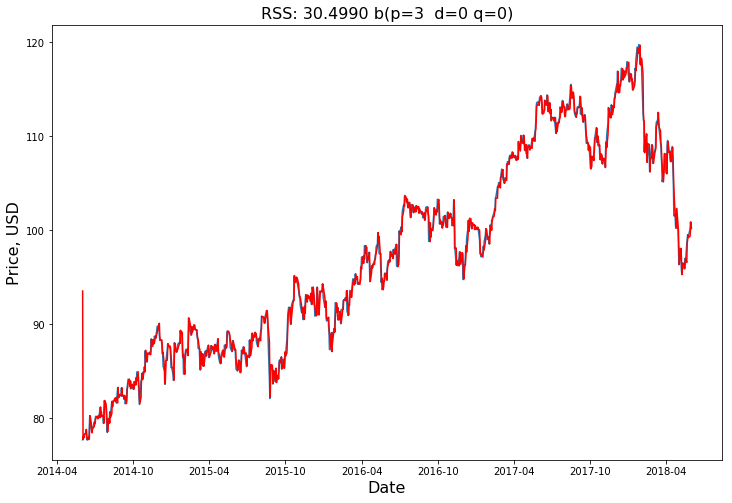

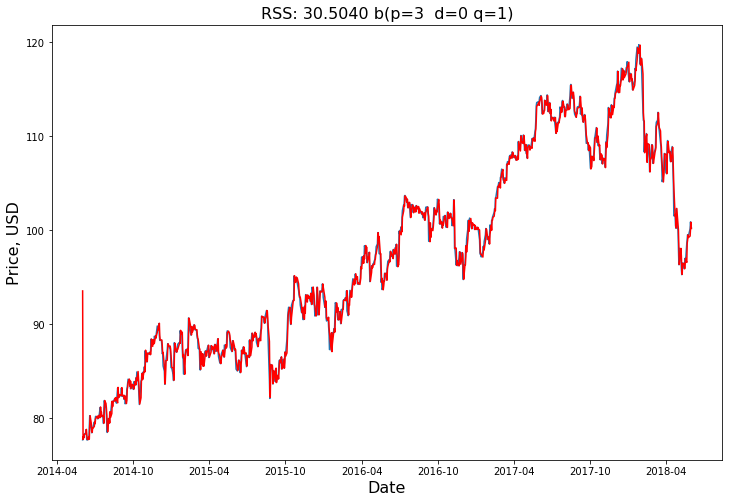

C:\Users\ML\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


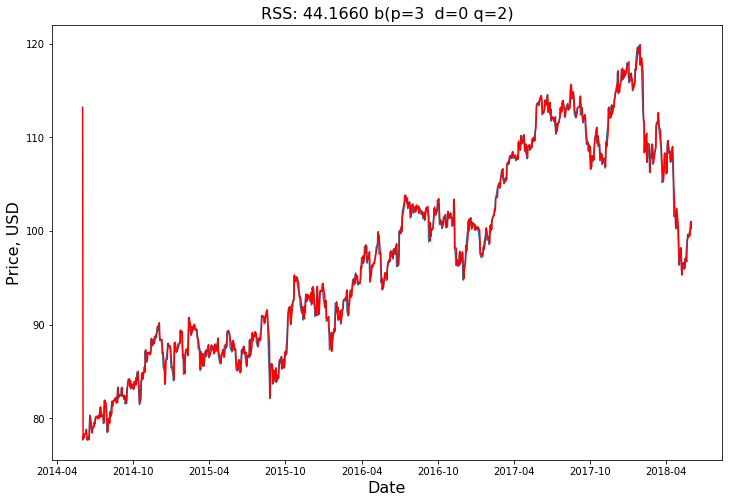

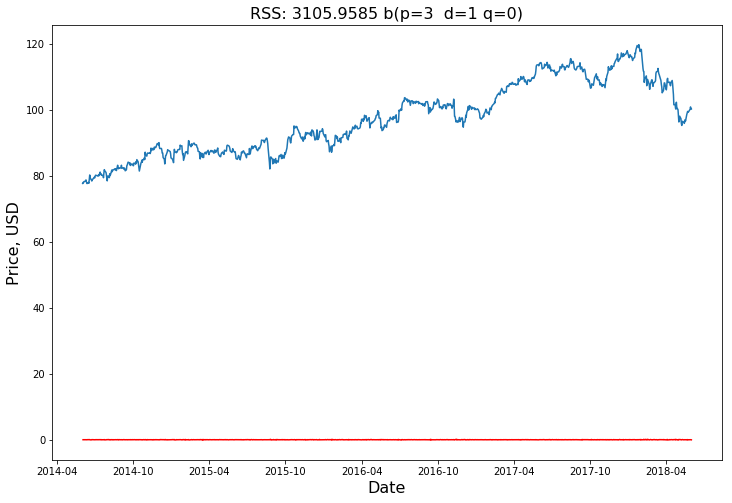

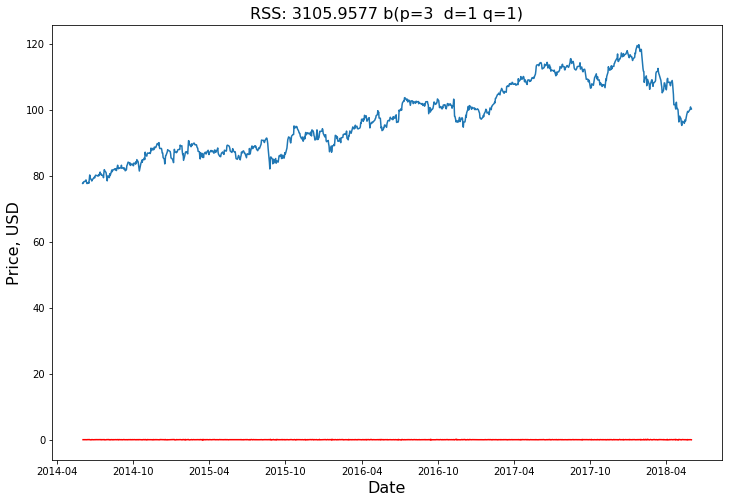

C:\Users\ML\Anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:584: RuntimeWarning: overflow encountered in exp
  newparams = ((1-np.exp(-params))/
C:\Users\ML\Anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:585: RuntimeWarning: overflow encountered in exp
  (1+np.exp(-params))).copy()
C:\Users\ML\Anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:585: RuntimeWarning: invalid value encountered in true_divide
  (1+np.exp(-params))).copy()
C:\Users\ML\Anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:586: RuntimeWarning: overflow encountered in exp
  tmp = ((1-np.exp(-params))/
C:\Users\ML\Anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:587: RuntimeWarning: overflow encountered in exp
  (1+np.exp(-params))).copy()
C:\Users\ML\Anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:587: RuntimeWarning: invalid value encountered in true_divide
  (1+np.exp(-params))).copy()


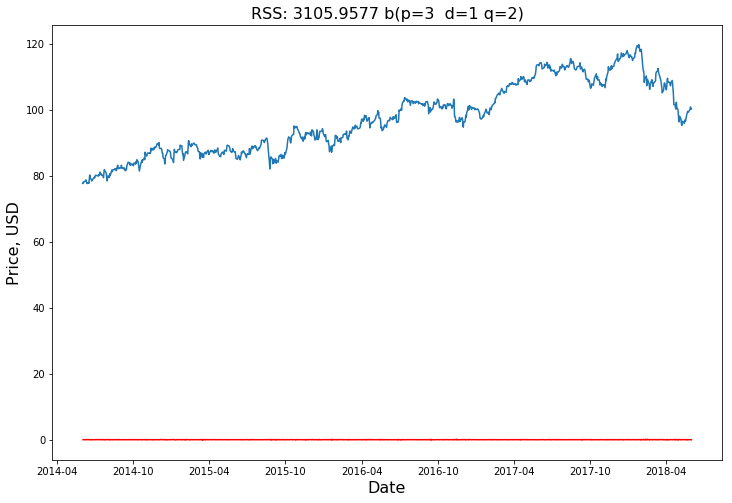

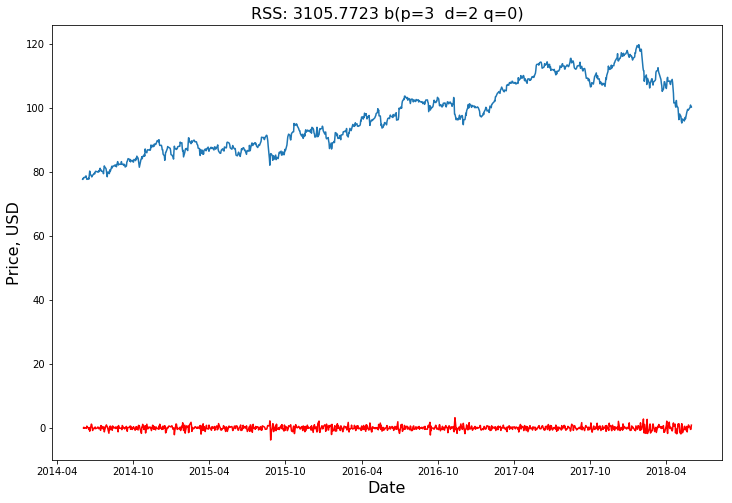

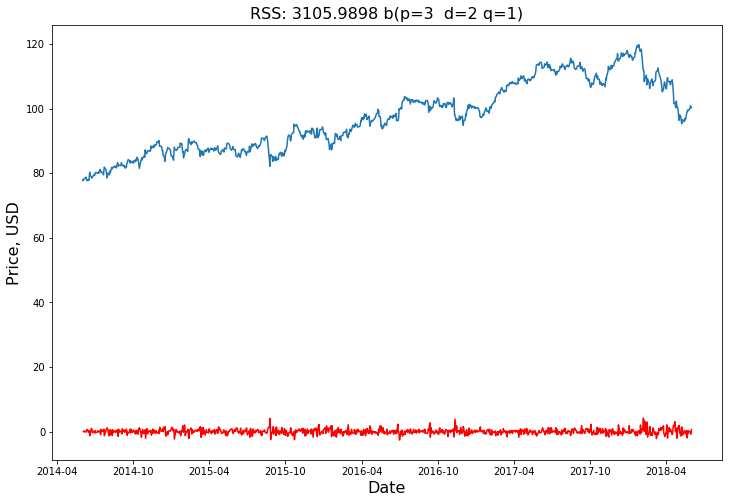

C:\Users\ML\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


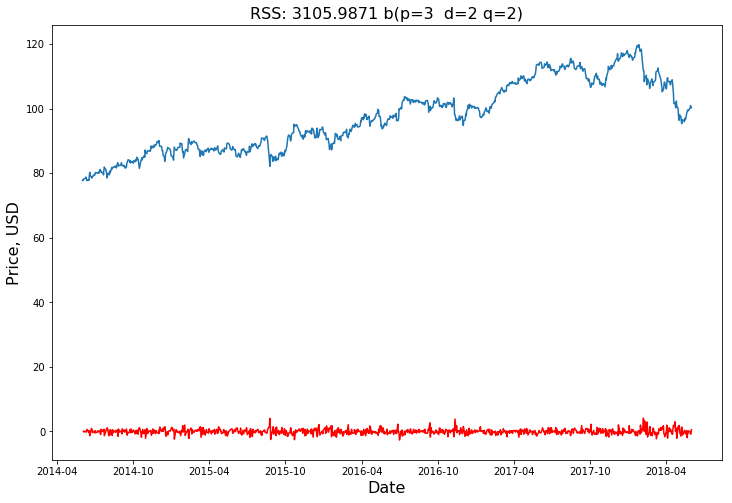

In [12]:
from statsmodels.tsa.arima_model import ARIMA
price = price.astype(float)
loss_best = 1E16
best_ints = [-1,-1,-1]
result = []
plt.figure(figsize=(20, 4))
for p in range(4):
    for d in range(3):
        for q in range(3):
            model = ARIMA(price.dropna(), order=(p, d, q))  
            try:
                results_ARIMA = model.fit(disp=-1)
            except ValueError:
                pass
            except:
                pass
            plt.plot(price)
            plt.plot(results_ARIMA.fittedvalues, color='red')
            x=pd.DataFrame(results_ARIMA.fittedvalues)
            x=x.join(price)
            x['out']=(x.iloc[:,0]-x.iloc[:,1])**2
            loss=np.sqrt(x['out'].sum())
            plt.title('RSS: %.4f b(p=%i  d=%i q=%i)' % (loss, p, d, q), fontsize=16)
            plt.ylabel('Price, USD', fontsize=16)
            plt.xlabel('Date', fontsize=16)
            plt.show()
            if loss < loss_best:
#                 print(loss)
                loss_best = loss
                best_ints=[p,d,q]
            
            # result logging
            result.append([p, d, q, loss])

### <span style="color:red">  Brute-Force grid-search result

### As shown on the below, all the ARIMA configuration with d-value being higher than 0 fails to predict any value and result in high RMSE values.

C:\Users\ML\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


The lowest RMSE =  30.4990231514
ARIMA pdq values for the lowest RMSE = [3, 0, 0]


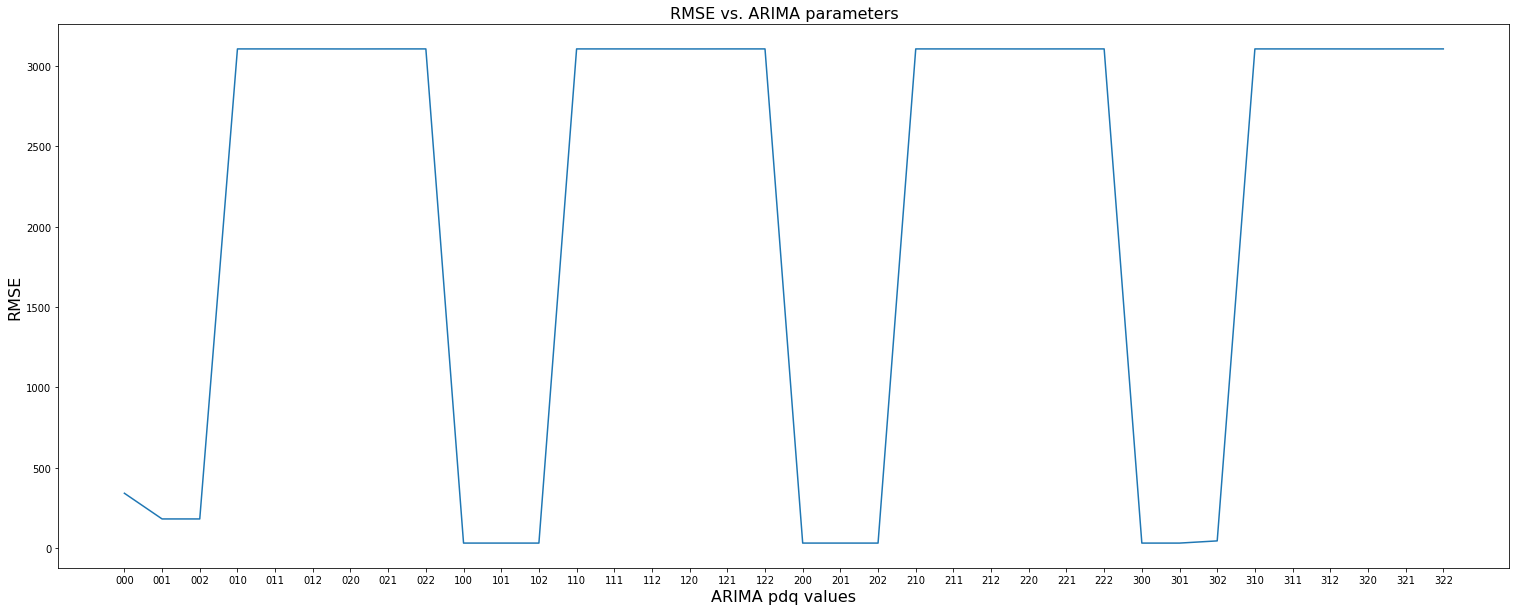

In [16]:
# Cancatenating p, d, and q values to plot
result = pd.DataFrame(result, columns = ['p','d','q','RMSE'])
result['pdq'] = 'a'
for i in range(len(result)):
    result.pdq[i] = str(result.p[i])+str(result.d[i])+str(result.q[i])

# plot RMSE
fig, ax = plt.subplots(figsize=(26, 10))
result.RMSE.plot()
ax.set_xticklabels(labels = result.pdq)
plt.xticks(np.arange(len(result)))
plt.title('RMSE vs. ARIMA parameters', fontsize=16)
plt.ylabel('RMSE', fontsize=16)
plt.xlabel('ARIMA pdq values', fontsize=16)


print('The lowest RMSE = ', loss_best)
print('ARIMA pdq values for the lowest RMSE =', best_ints)

### Among the ARIMA configuration that is working, all models with AR term higher than 0 is resulting in similar RMSE values.  

Text(0.5,0,'ARIMA pdq values')

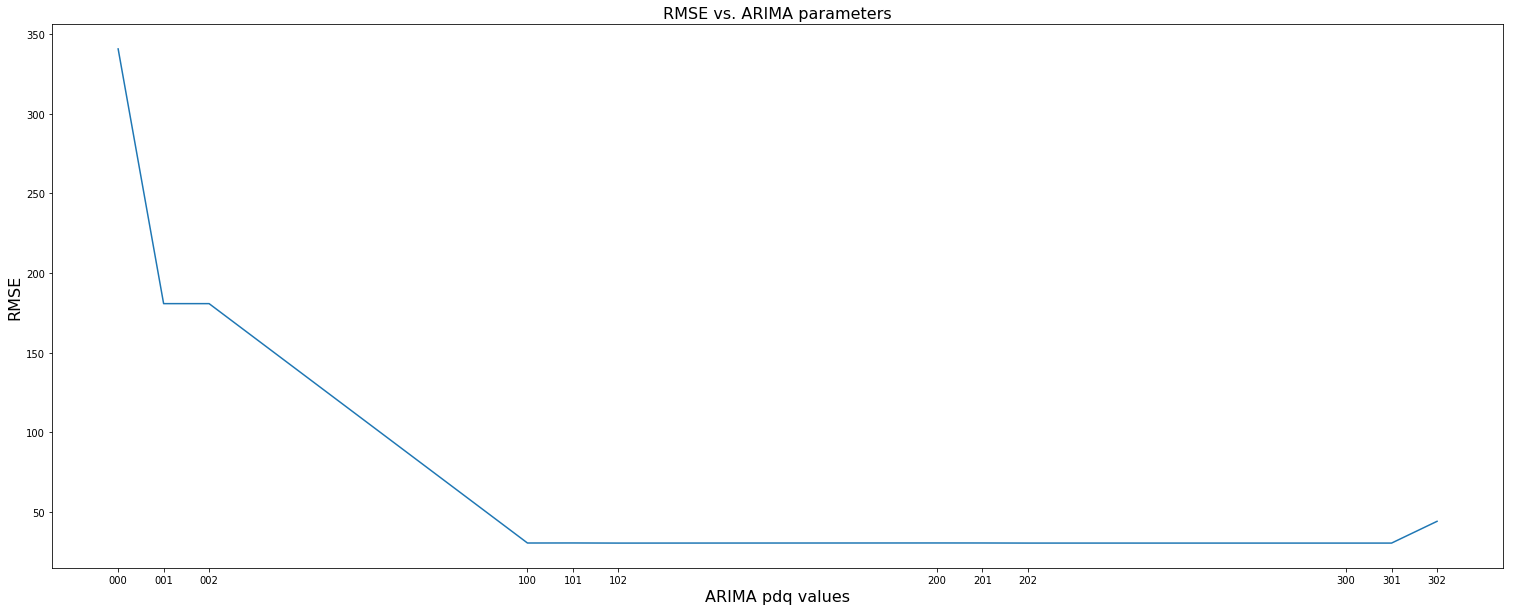

In [40]:
# plot RMSE
fig, ax = plt.subplots(figsize=(26, 10))
rowNum = result.index[result.RMSE<1000];
result.RMSE.iloc[rowNum].plot()
ax.set_xticklabels(labels = result.pdq.iloc[rowNum])
plt.xticks(rowNum)
plt.title('RMSE vs. ARIMA parameters', fontsize=16)
plt.ylabel('RMSE', fontsize=16)
plt.xlabel('ARIMA pdq values', fontsize=16)

In [26]:
# plot RMSE
result.loc[result.RMSE<1000]

,p,d,q,RMSE,pdq
0,0,0,0,340.660371,000
1,0,0,1,180.785863,001
2,0,0,2,180.785863,002
9,1,0,0,30.549098,100
10,1,0,1,30.579882,101
11,1,0,2,30.500724,102
18,2,0,0,30.578835,200
19,2,0,1,30.566489,201
20,2,0,2,30.506090,202
27,3,0,0,30.499023,300


# <span style="color:red"> Step4: Results - Final ARIMA parameter decision
    
### The autocorrelation and partial autocorrelation plot indicated that this stock price is a random-walk, ARIMA (0,1,0).  Based on the brute-force grid search, the lowest RMSE score was 30.5 with ARIMA(3,0,0) model.  If the insignificant difference in the RMSE is ignored, the grid-search is essentially giving an ARIMA(1,0,0) model, which is same as AR(1) model.  

### AR(1) model results are same as below.  The autoregressive coefficient of the AR(1) model is very close to 1, which is a random-walk.  

                              ARMA Model Results                              
Dep. Variable:                  close   No. Observations:                 1009
Model:                     ARMA(1, 0)   Log Likelihood               -1236.324
Method:                       css-mle   S.D. of innovations              0.822
Date:                Mon, 04 Jun 2018   AIC                           2478.647
Time:                        20:06:16   BIC                           2493.397
Sample:                    06-02-2014   HQIC                          2484.251
                         - 06-01-2018                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const          93.6127      7.837     11.944      0.000      78.252     108.974
ar.L1.close     0.9975      0.002    507.014      0.000       0.994       1.001
                                    Roots       

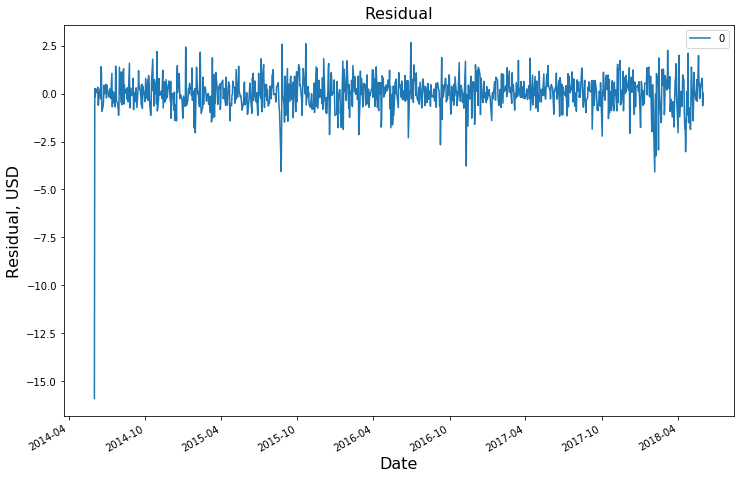

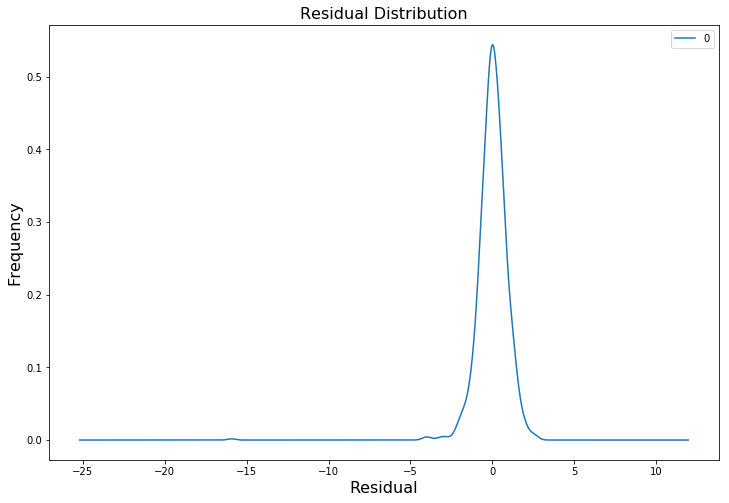

In [43]:
model = ARIMA(price.dropna(), order=(1,0,0))
model_fit = model.fit(disp=0)
print(model_fit.summary())
# plot residual errors
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()
plt.title('Residual', fontsize=16)
plt.ylabel('Residual, USD', fontsize=16)
plt.xlabel('Date', fontsize=16)

residuals.plot(kind='kde')
plt.title('Residual Distribution', fontsize=16)
plt.ylabel('Frequency', fontsize=16)
plt.xlabel('Residual', fontsize=16)
print(residuals.describe())

# <span style="color:blue"> Conclusion:
    
### The stock price of PepsiCo company is modeled with ARIMA model.  The most reasonable models are either ARIMA(1,0,0) or ARIMA(0,1,0).  Both models are telling that the next value will be determined at random.  